In [1]:
import clip
import numpy as np
import torch
from pkg_resources import packaging
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader, Dataset

from collections import OrderedDict
import torch
import torch.nn as nn
from tqdm import tqdm

print("Torch version:", torch.__version__)


Torch version: 2.0.1+cu117


Loading the model

In [2]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


View images and descriptions we are going to use for fine-tuning

In [3]:
IMAGES_DIR = './my_images'
DESCRIPTIONS_FILE = './my_descriptions.txt'

In [4]:
def read_descriptions(file_path):
    # Initialize an empty dictionary
    descriptions = {}

    # Open the text file for reading
    with open(file_path, 'r') as file:
        # Iterate through each line
        for line in file:
            # Split the line into key and value using the tab separator
            key, value = line.strip().split('\t')
            
            # Add key-value pair to the dictionary
            descriptions[key] = value
    
    return descriptions

In [5]:
descriptions = read_descriptions(DESCRIPTIONS_FILE)

In [6]:
def read_images(images_dir, descriptions):
    original_images = []
    images = []
    texts = []
    plt.figure(figsize=(20, 5))

    for filename in [filename for filename in os.listdir(images_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
        if filename not in descriptions:
            continue

        image = Image.open(os.path.join(images_dir, filename)).convert("RGB")
    
        plt.subplot(2, 4, len(images) + 1)
        plt.imshow(image)
        plt.title(f"{filename}\n{descriptions[filename]}")
        plt.xticks([])
        plt.yticks([])

        original_images.append(image)
        images.append(preprocess(image))
        texts.append(descriptions[filename])

    plt.tight_layout()

    return images, original_images

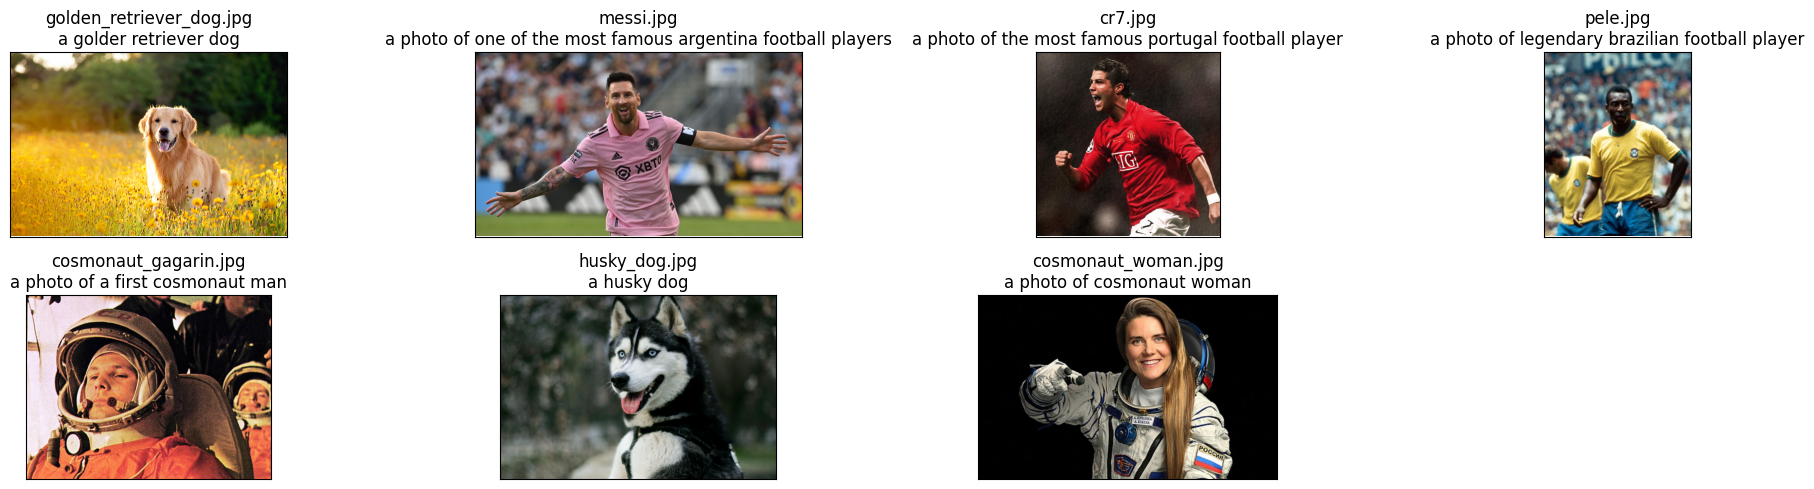

In [7]:
images, original_images = read_images(IMAGES_DIR, descriptions)

Let's check cosine similarity between source images before fine-tuning

In [8]:
def get_cosine_similarity_score_between_images(images1, images2):
    image_input_1 = torch.tensor(np.stack(images1)).cuda()
    image_input_2 = torch.tensor(np.stack(images2)).cuda()

    with torch.no_grad():
        image_features_1 = model.encode_image(image_input_1).float()
        image_features_2 = model.encode_image(image_input_2).float()

    image_features_1 /= image_features_1.norm(dim=-1, keepdim=True)
    image_features_2 /= image_features_2.norm(dim=-1, keepdim=True)
    similarity = image_features_1.cpu().numpy() @ image_features_2.cpu().numpy().T

    return similarity

In [9]:
def show_cosine_similarity_between_images(images, original_images):
    similarity = get_cosine_similarity_score_between_images(images, images)

    count = len(images)

    plt.figure(figsize=(20, 15))
    plt.imshow(similarity, vmin=0.1, vmax=0.3)
    
    for i, image in enumerate(original_images):
        plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.5, -0.5), origin="lower")
        plt.imshow(image, extent=(-1.5, -0.5, -0.5 + i, 0.5 + i, ), origin="lower")

    for x in range(similarity.shape[1]):
        for y in range(similarity.shape[0]):
            plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

    for side in ["left", "top", "right", "bottom"]:
        plt.gca().spines[side].set_visible(False)

    plt.xlim([-1.5, count + 1])
    plt.ylim([count - 0.5, -1.5])

    plt.title("Cosine similarity between images", size=20)

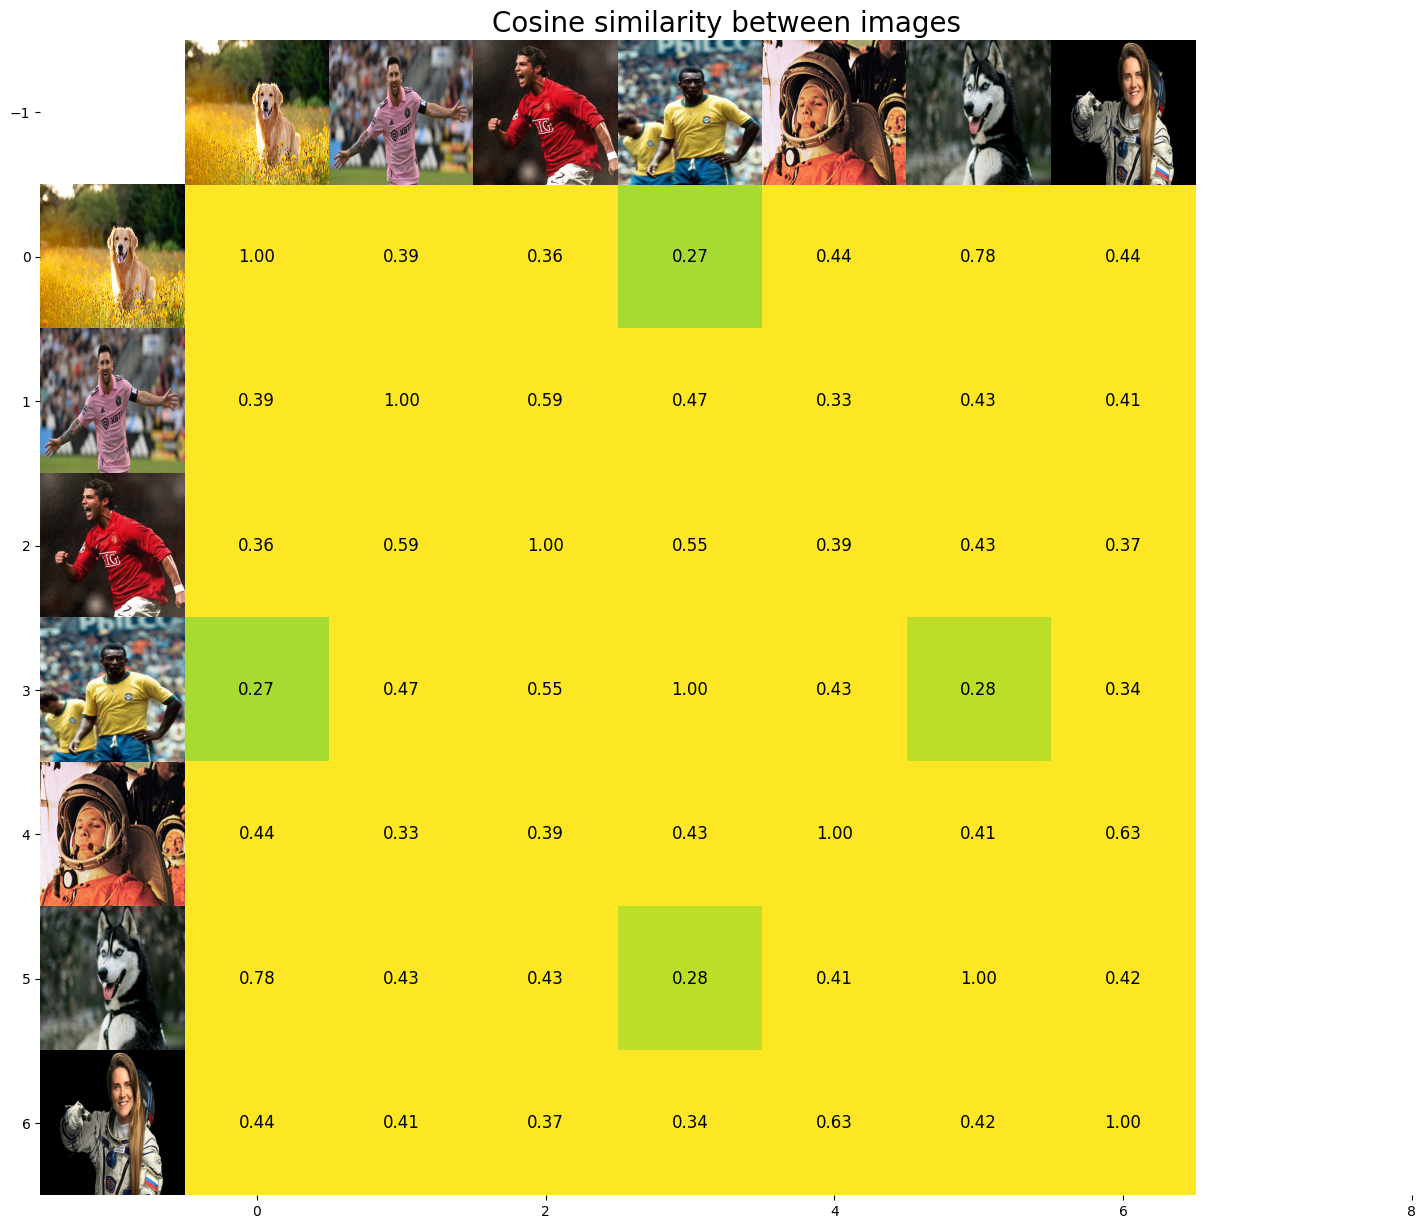

In [10]:
show_cosine_similarity_between_images(images, original_images)

Now let's train model on our images

At first let's define own data set

In [11]:
class MyImagesDataset(Dataset):
    def __init__(self, images_dir: str, descriptions_file: str) -> None:
        super().__init__()

        self.images_dir = images_dir

        files = [filename for filename in os.listdir(images_dir) if filename.endswith(".png") or filename.endswith(".jpg")]
        descriptions = read_descriptions(descriptions_file)

        self.images_data = []
        for filename in files:
            #self.images_data.append((filename, descriptions[filename]))
            self.images_data.append((filename, clip.tokenize("This is " + descriptions[filename])[0].cuda()))
    
    def __len__(self):
        return len(self.images_data)

    def __getitem__(self, index: int):
        item = self.images_data[index]
        image = preprocess(Image.open(os.path.join(self.images_dir, item[0])).convert("RGB"))
        desc = item[1]

        return image, desc

In [12]:
my_dataset = MyImagesDataset(IMAGES_DIR, DESCRIPTIONS_FILE)
train_dataloader = DataLoader(my_dataset)

Now let's fine-tune model with our images:

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 

In [15]:
def fine_tune_model(model, dataloader):
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2)
    loss_img = nn.CrossEntropyLoss()
    loss_txt = nn.CrossEntropyLoss()

    model.train()

    num_epochs = 5
    for epoch in range(num_epochs):
        pbar = tqdm(dataloader, total=len(dataloader))
        for batch in pbar:
            optimizer.zero_grad()

            images,texts = batch 
            
            images= images.to(device)
            texts = texts.to(device)

            # Forward pass
            logits_per_image, logits_per_text = model(images, texts)

            # Compute loss
            ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
            total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2

            # Backward pass
            total_loss.backward()
            if device == "cpu":
                optimizer.step()
            else : 
                convert_models_to_fp32(model)
                optimizer.step()
                clip.model.convert_weights(model)

            pbar.set_description(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss.item():.4f}")

In [16]:
fine_tune_model(model, train_dataloader)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/5, Loss: 0.0000: 100%|██████████| 7/7 [00:01<00:00,  6.83it/s]


In [17]:
model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

Now let's check if we have any changes on images cosine similarity values

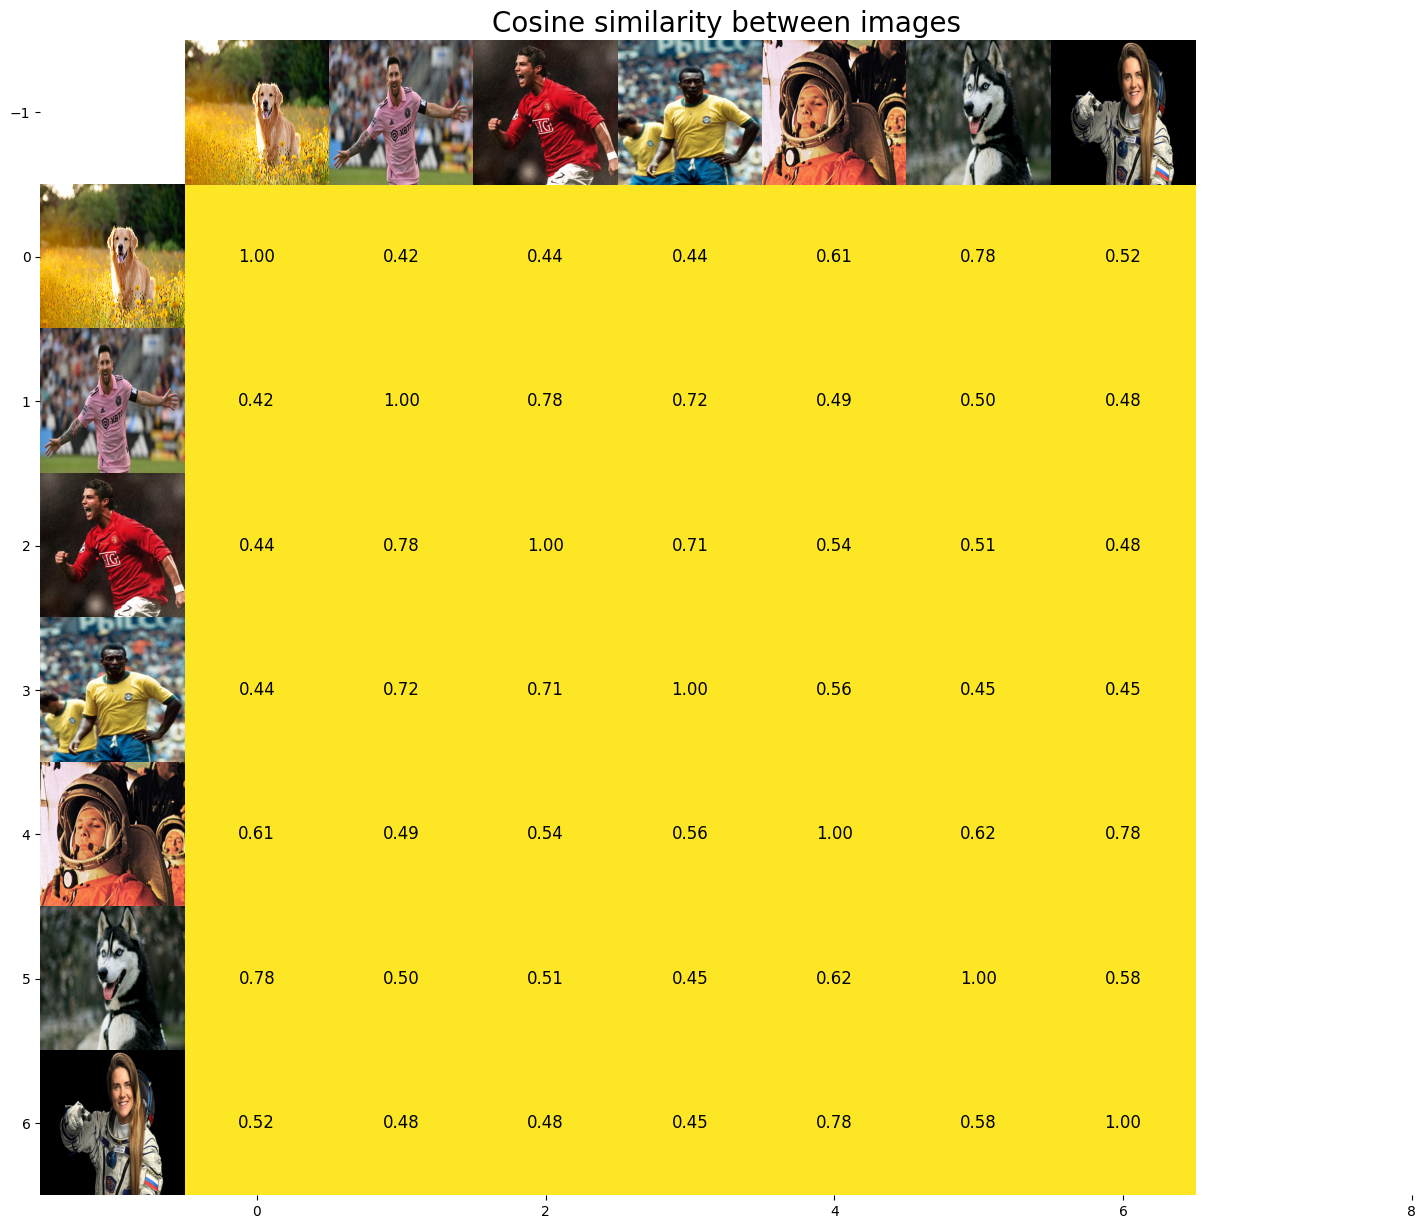

In [18]:
show_cosine_similarity_between_images(images, original_images)

As we can see each of groups of images(football players, cosmonauts, dogs) now has higher inner similarity scores.

Let's define function to get cosine similarity score between two images:

In [19]:
def get_cosine_similarity_score_between_two_images(image1, image2):
    similarity = get_cosine_similarity_score_between_images(image1.unsqueeze(0), image2.unsqueeze(0))

    return similarity.item()

For example between husky and golder retriever:

In [21]:
get_cosine_similarity_score_between_two_images(images[0], images[5])

0.7836059331893921